In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import libraries

In [ ]:
pip install transformers #essential for loading all transformer models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 9.5 MB/s 
     |████████████████████████████████| 7.6 MB 48.5 MB/s 
     |████████████████████████████████| 163 kB 35.2 MB/s 


In [ ]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import bs4
import nltk
import nltk.tokenize as tok
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:

    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)


Number of replicas: 1


In [ ]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 10

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/medicodio/Master data.csv')
df.head()

,S.no,subscriber_id,section,report_type,patient_last_name,patient_first_name,patient_gender,date_of_birth,chart_record_id,file_name,...,expected_cpt,expected_modifier,notes,description_of_condition,description_of_procedure,post_op_impression,post_op_order,notes1,created_by,created_ts
0,1,20210809104,GI,OPERATIVE REPORT,ABC,DEF,M,01/01/1952,20210501101,ABCD_64,...,45384,33,ANESTHESIA: Propofol.|ESTIMATED BLOOD LOSS: Mi...,NaN,Sandra was brought to the endoscopy suite and ...,1. Small colon polyps. 2. Healthy anastomosis.,NaN,PLAN: Follow-up colonoscopy in 3 years or soon...,System,02:26.8
1,2,20210809104,GI,OPERATIVE REPORT,DEF,GHI,M,01/01/1952,20210501101,ABCD_64,...,45384,PT,ANESTHESIA: Propofol.|ESTIMATED BLOOD LOSS: Mi...,NaN,Sandra was brought to the endoscopy suite and ...,1. Small colon polyps. 2. Healthy anastomosis.,NaN,PLAN: Follow-up colonoscopy in 3 years or soon...,System,02:26.8
2,3,20210809104,GI,OPERATIVE REPORT,GHI,JKW,M,01/01/1952,20210501101,ABCD_64,...,45384,33,ANESTHESIA: Propofol.|ESTIMATED BLOOD LOSS: Mi...,NaN,Sandra was brought to the endoscopy suite and ...,1. Small colon polyps. 2. Healthy anastomosis.,NaN,PLAN: Follow-up colonoscopy in 3 years or soon...,System,02:26.8
3,4,20210809104,GI,OPERATIVE REPORT,XYZ,ABC,M,01/01/1952,20210501101,ABCD_64,...,45384,PT,ANESTHESIA: Propofol.|ESTIMATED BLOOD LOSS: Mi...,NaN,Sandra was brought to the endoscopy suite and ...,1. Small colon polyps. 2. Healthy anastomosis.,NaN,PLAN: Follow-up colonoscopy in 3 years or soon...,System,02:26.8
4,5,20210809104,GI,OPERATIVE REPORT,ABC,DEF,M,01/01/1952,20210501101,ABCD_64,...,45384,PT,ANESTHESIA: Propofol.|ESTIMATED BLOOD LOSS: Mi...,NaN,Sandra was brought to the endoscopy suite and ...,1. Small colon polyps. 2. Healthy anastomosis.,NaN,PLAN: Follow-up colonoscopy in 3 years or soon...,System,02:26.8


In [ ]:
df=df[['description_of_procedure','expected_icd']]

In [ ]:
df.head()

,description_of_procedure,expected_icd
0,Sandra was brought to the endoscopy suite and ...,K62.1
1,Sandra was brought to the endoscopy suite and ...,Z12.11
2,Sandra was brought to the endoscopy suite and ...,Z12.11
3,Sandra was brought to the endoscopy suite and ...,K62.1
4,Sandra was brought to the endoscopy suite and ...,Z98.0


#Data analysis

In [ ]:
def calculate_stats(df, split_char=' '):
    categories = df['expected_icd'].unique()

    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['description_of_procedure']
        text = re.sub(r"\s+", ' ', description_of_procedure) # Normalize
        text = text.split(split_char)
        l = len(text)

        category = row['expected_icd']

        all_lengths.append(l)
        per_category['lengths'][expected_icd].append(l)

    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])

    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['expected_icd'].unique()
    n_rows = math.ceil(len(categories) / n_cols)

    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')

    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('expected_icd: %s' % c)

        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

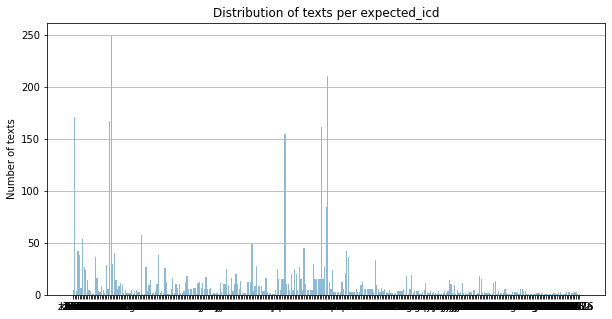

Counter({'m54.16': 249, 'm54.2': 210, 'z12.11': 171, 'm54.12': 167, 'm54.5': 161, 'd13.0': 155, 'm45.5': 84, 'k22.2': 58, 'k57.30': 54, 'd12.0': 49, 'd13.1': 45, 'k63.5': 42, 'n87.1': 42, 'z41.1': 40, 'z87.19': 38, 'm50.122': 38, 'z83.71': 36, 'c55': 36, 'c56.9': 33, 'l98.7': 30, 'd12.2': 30, 'h25.811': 29, 'd12.3': 28, 'k64.8': 27, 'g89.21': 27, 'k21.9': 27, 'm54.4': 27, 'm51.16': 26, 's01.512a': 25, 'd10.0': 25, 'm26.12': 25, 'k44.9': 24, 'm75.41': 24, 'c51.9': 21, 'n80.0': 20, 'k13.21': 20, 't18.128a': 20, 'm47.816': 19, 'd18.01': 18, 'c44.41': 18, 'n39.46': 18, 'c44.01': 17, 'h25.12': 16, 'k22.5': 16, 'j35.2': 16, 'z86.010': 16, 's01.511a': 15, 'q36.0': 15, 'k09.9': 15, 'i85.00': 15, 'd12.4': 15, 'd12.5': 15, 'd12.6': 15, 'd12.8': 15, 'm23.91': 15, 'n20.1': 15, 'd50.9': 14, 'n64.82': 14, 'm51.26': 14, 'h65.03': 14, 'd23.4': 13, 'm48.07': 13, 'z80.0': 12, 'd23.61': 12, 'c44.519': 12, 'h26.131': 12, 'h27.8': 12, 'h40.31x4': 12, 'm23.92': 12, 'n90.1': 12, 'n73.6': 12, 'h25.11': 11, 'c

In [ ]:
categories = df[['expected_icd']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per expected_icd')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [ ]:
#df_stats = calculate_stats(df)
#df_stats['per_category']

In [ ]:
#display_lengths_histograms(df_stats)

#Preprocessing

In [ ]:
  def basic_clean(row):
    row['description_of_procedure'] = re.sub(' +', ' ', row['description_of_procedure']).strip().lower()
    row['expected_icd'] = re.sub(' +', ' ', row['expected_icd']).strip().lower()
    return row

# Remove NaN rows
df = df[df['description_of_procedure'].notna()]
df = df[df['expected_icd'].notna()]
#test = test[test['description_of_procedure'].notna()]
#test = test[test['premise'].notna()]

# Remove double spaces and starting/ending as well
df = df.apply(basic_clean, axis=1).reset_index()
#test = test.apply(basic_clean, axis=1).reset_index()

In [ ]:
df.head()

,index,description_of_procedure,expected_icd
0,0,sandra was brought to the endoscopy suite and ...,k62.1
1,1,sandra was brought to the endoscopy suite and ...,z12.11
2,2,sandra was brought to the endoscopy suite and ...,z12.11
3,3,sandra was brought to the endoscopy suite and ...,k62.1
4,4,sandra was brought to the endoscopy suite and ...,z98.0


In [ ]:
df.describe()

,index
count,3623.000000
mean,1811.898703
std,1046.172073
min,0.000000
25%,906.500000
50%,1812.000000
75%,2717.500000
max,3623.000000


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')

    return text

In [ ]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)

    return [item for item in newlist if item != '']

In [ ]:
def clean_punct(text):
    words = token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)

    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))

    filtered_list = strip_list_noempty(punctuation_filtered)

    return ' '.join(map(str, filtered_list))

In [ ]:
def lemitizeWords(text):
    words = token.tokenize(text)
    listLemma = []

    for w in words:
        x = lemma.lemmatize(w, pos = "v")
        listLemma.append(x)

    return ' '.join(map(str, listLemma))

In [ ]:
def stopWordsRemove(text):
    stop_words = set(stopwords.words("english"))
    words = token.tokenize(text)
    filtered = [w for w in words if not w in stop_words]

    return ' '.join(map(str, filtered))

In [ ]:
def stringToList(text):
    listRes = list(text.split(" "))
    return listRes

In [ ]:
%%time
# Wall time: 48.9 s

flat_list = [item for sublist in df['expected_icd'].values for item in sublist]
keywords = nltk.FreqDist(flat_list)
keywords = nltk.FreqDist(keywords)
frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

# ToktokTokenizer is a fast, simple, multilingual tokenizer.
token = tok.ToktokTokenizer()
lemma = WordNetLemmatizer()
punct = '!"$%&\'()*,./:;<=>?@[\\]^_`{|}~'

# Converting html to text in the body
df['description_of_procedure'] = df['description_of_procedure'].apply(lambda x: bs4.BeautifulSoup(x, 'lxml').get_text())
df['description_of_procedure'] = df['description_of_procedure'].apply(lambda x: clean_text(x))
df['description_of_procedure'] = df['description_of_procedure'].apply(lambda x: clean_punct(x))
df['description_of_procedure'] = df['description_of_procedure'].apply(lambda x: lemitizeWords(x))
df['description_of_procedure'] = df['description_of_procedure'].apply(lambda x: stopWordsRemove(x))


CPU times: user 9.85 s, sys: 80.8 ms, total: 9.93 s
Wall time: 10.6 s


In [ ]:
df.head()

,index,description_of_procedure,expected_icd
0,0,sandra bring endoscopy suite standard pause ob...,k62.1
1,1,sandra bring endoscopy suite standard pause ob...,z12.11
2,2,sandra bring endoscopy suite standard pause ob...,z12.11
3,3,sandra bring endoscopy suite standard pause ob...,k62.1
4,4,sandra bring endoscopy suite standard pause ob...,z98.0


In [ ]:
X_data = df[['description_of_procedure']].to_numpy().reshape(-1)
y_data = df[['expected_icd']].to_numpy().reshape(-1)

In [ ]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df['expected_icd'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 3623
Number of categories: 321
Done!


In [ ]:
X_data

array(['sandra bring endoscopy suite standard pause observe entire staff patientâ€ ™s name procedure clearly identify next place leave lateral position pad accord standard protocol connect appropriate monitor devices o2 administer via nasal cannula induction anesthesia digital rectal exam perform well-lubricated adult colonoscope insert anus advance underneath direct visualization level ileo-transverse colon anastomosis ileo-transverse colon anastomosis widely patent sign mass stricture sign polyp inflammation next colonoscope withdraw take care inspect color character integrity mucosa anastomosis anus two small rectal polyps remove hot biopsy lesions identify .',
       'sandra bring endoscopy suite standard pause observe entire staff patientâ€ ™s name procedure clearly identify next place leave lateral position pad accord standard protocol connect appropriate monitor devices o2 administer via nasal cannula induction anesthesia digital rectal exam perform well-lubricated adult colonos

#MODEL

In [ ]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)

        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])

        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN

        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')

        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [ ]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c

    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 'k62.1',
 1: 'z12.11',
 2: 'z98.0',
 3: 'k63.5',
 4: 'z87.19',
 5: 'k64.4',
 6: 'k57.30',
 7: 'k64.8',
 8: 'k44.9',
 9: 'd50.9',
 10: 'k21.00',
 11: 'k22.70',
 12: 'k26.9',
 13: 'k29.70',
 14: 'z83.71',
 15: 'h25.12',
 16: 'h40.1122',
 17: 'h26.491',
 18: 'h21.81',
 19: 'h26.493',
 20: 'h26.8',
 21: 'h25.811',
 22: 'h26.9',
 23: 'm54.12',
 24: 'm54.16',
 25: 'l98.7',
 26: 'z41.1',
 27: 'n64.82',
 28: 'n62',
 29: 'n64.81',
 30: 'h25.11',
 31: 'h57.03',
 32: 'm95.0',
 33: 'h25.812',
 34: 'h25.21',
 35: 'h25.041',
 36: 'h25.9',
 37: 'k62.5',
 38: 'k20.90',
 39: 'k31.7',
 40: 'k92.1',
 41: 'r12',
 42: 'r10.13',
 43: 'k22.2',
 44: 'k63.4',
 45: 'z98.890',
 46: 'g89.21',
 47: 'm50.21',
 48: 'm53.3',
 49: 'm51.26',
 50: 'm50.223',
 51: 'm53.2x8',
 52: 'm50.123',
 53: 'm50.022',
 54: 'm50.122',
 55: 'm50.222',
 56: 'm53.2x7',
 57: 'm71.38',
 58: 'm51.16',
 59: 'z80.0',
 60: 'k63.89',
 61: 'k57.32',
 62: 'r19.7',
 63: 'k22.5',
 64: 'k57.10',
 65: 'k22.8',
 66: 'k31.5',
 67: 'r10.9',
 68: 'd

In [ ]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=100) # random_state to reproduce results

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [ ]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [ ]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

#Training

In [ ]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=40,
                        batch_size=6,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/40


423/423 [==============================] - 206s 434ms/step - loss: 3.2142 - accuracy: 0.3549 - val_loss: 2.1912 - val_accuracy: 0.4867
Epoch 2/40
423/423 [==============================] - 180s 427ms/step - loss: 1.5205 - accuracy: 0.5690 - val_loss: 1.5766 - val_accuracy: 0.5860
Epoch 3/40
423/423 [==============================] - 181s 427ms/step - loss: 1.0979 - accuracy: 0.6262 - val_loss: 1.5596 - val_accuracy: 0.6026
Epoch 4/40
423/423 [==============================] - 180s 426ms/step - loss: 0.9705 - accuracy: 0.6447 - val_loss: 1.4204 - val_accuracy: 0.6173
Epoch 5/40
423/423 [==============================] - 180s 426ms/step - loss: 0.8734 - accuracy: 0.6471 - val_loss: 1.4556 - val_accuracy: 0.6228
Epoch 6/40
423/423 [==============================] - 180s 427ms/step - loss: 0.8352 - accuracy: 0.6569 - val_loss: 1.4121 - val_accuracy: 0.6118
Epoch 7/40
423/423 [==============================] - 180s 426ms/step - loss: 0.7882 - accuracy: 0.6688 - val_loss: 1.3488 - val_accura

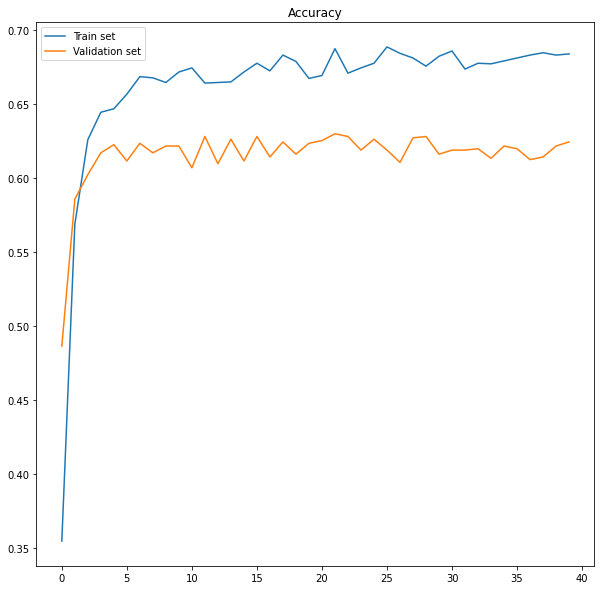

In [ ]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

#Evaluation

In [ ]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names,
                              columns=label_names)

    figure = plt.figure(figsize=(100, 100))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 62.47%


In [ ]:
plot_confusion_matrix(X_test, y_test, model)

In [ ]:
#output.argmax(dim=1)

In [ ]:
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names,
                              columns=label_names)

#Predictions

In [ ]:
for i in range(320):
  maxValueIndex = con_mat_df.idxmax()

print(maxValueIndex)


0        6
1        0
2        0
3      114
4       60
      ... 
316      0
317      0
318    317
319      0
320      0
Length: 321, dtype: int64


In [ ]:
for i in range(319):
 print("actual tags: "+category_to_name[i]  +"        :predicted tags : "+category_to_name[maxValueIndex[i]])

actual tags: k62.1        :predicted tags : k57.30
actual tags: z12.11        :predicted tags : k62.1
actual tags: z98.0        :predicted tags : k62.1
actual tags: k63.5        :predicted tags : k31.89
actual tags: z87.19        :predicted tags : k63.89
actual tags: k64.4        :predicted tags : k62.5
actual tags: k57.30        :predicted tags : k63.5
actual tags: k64.8        :predicted tags : r19.7
actual tags: k44.9        :predicted tags : k22.70
actual tags: d50.9        :predicted tags : z98.0
actual tags: k21.00        :predicted tags : k44.9
actual tags: k22.70        :predicted tags : k21.00
actual tags: k26.9        :predicted tags : k62.1
actual tags: k29.70        :predicted tags : k62.1
actual tags: z83.71        :predicted tags : d12.3
actual tags: h25.12        :predicted tags : h40.1122
actual tags: h40.1122        :predicted tags : k62.1
actual tags: h26.491        :predicted tags : k62.1
actual tags: h21.81        :predicted tags : k62.1
actual tags: h26.493        

In [ ]:
# # Get user input
# text = input("Enter text to classify: ")

In [ ]:
# # Encode the user input
# encoded_text = tokenizer.encode_plus(
#     text,
#     add_special_tokens=True,
#     return_attention_mask=True,
#     return_tensors='tf'
# )

# # Get the model's predictions for the encoded text
# outputs = model(encoded_text)
# probs = tf.nn.softmax(outputs.logits, axis=-1)

# # Determine the threshold for outputting a class
# threshold = 0.5

# # Output the classes with probability greater than the threshold
# for i, class_prob in enumerate(probs[0]):
#     if class_prob > threshold:
#         print(f"Class {i}: {class_prob.numpy()}")